In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class GenderDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu3/gender/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["female", "male"]
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu3/gender/'
train_dataset = GenderDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = GenderDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

15924
3058


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch
import torch.nn as nn

class MyEffnet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.backbone.classifier[1] = nn.Linear(1280, n_classes)
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [13]:
# from torchvision.models import resnet50, ResNet50_Weights
# import torch
# import torch.nn as nn

# class MyResnet(nn.Module):
#     def __init__(self, n_classes=2):
#         super().__init__()
        
#         sel
# #         self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
# #         del self.backbone.fc
# # #         self.fc1 = nn.Linear(2048, 1000)
# # #         self.drouput1 = nn.Dropout(0.5)
# # #         self.fc2 = nn.Linear(1000, 2)
# #         self.fc = nn.Linear(2048, n_classes)
    
#     def forward(self, x):
#         x = self.backbone.conv1(x)
#         x = self.backbone.bn1(x)
#         x = self.backbone.relu(x)
#         x = self.backbone.maxpool(x)
#         x = self.backbone.layer1(x)
#         x = self.backbone.layer2(x)
#         x = self.backbone.layer3(x)
#         x = self.backbone.layer4(x)
#         x = self.backbone.avgpool(x)

#         x = torch.flatten(x, 1)
# #         x = self.fc1(x)
# #         x = self.drouput1(x)
# #         x = self.fc2(x)
#         x = self.fc(x)
# #         x = nn.Sigmoid()(x)
#         return x

In [14]:
x = torch.randn(16, 3, 224, 224)
model = MyEffnet()
# print(model)
print(model(x).shape)

torch.Size([16, 2])


In [15]:
import torch.optim as optim
from tqdm import tqdm
epochs = 40
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

In [16]:
train_dataset = GenderDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = GenderDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

15924
3058


In [17]:
model = MyEffnet().to(device)
if os.path.exists('last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('last.pt'))
    else:
        model.load_state_dict(torch.load('last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) #optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) 

In [18]:
best_acc = 0
best_model = MyEffnet().to(device)
if os.path.exists('best.pt'):
    best_model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [19]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/40 Iter: 1991 Loss: 0.4332: 100%|██████████| 1991/1991 [03:24<00:00,  9.76it/s]


Epoch: 1/40 Test Loss: 0.3693 Test Acc: 0.8852


Epoch: 2/40 Iter: 1991 Loss: 0.0498: 100%|██████████| 1991/1991 [03:18<00:00, 10.01it/s]


Epoch: 2/40 Test Loss: 0.5681 Test Acc: 0.9097


Epoch: 3/40 Iter: 1991 Loss: 0.0247: 100%|██████████| 1991/1991 [03:19<00:00,  9.99it/s]


Epoch: 3/40 Test Loss: 0.2604 Test Acc: 0.8819


Epoch: 4/40 Iter: 1991 Loss: 0.0221: 100%|██████████| 1991/1991 [03:18<00:00, 10.02it/s]


Epoch: 4/40 Test Loss: 0.2683 Test Acc: 0.9091


Epoch: 5/40 Iter: 1991 Loss: 0.0482: 100%|██████████| 1991/1991 [03:19<00:00,  9.96it/s]


Epoch: 5/40 Test Loss: 0.1302 Test Acc: 0.9267


Epoch: 6/40 Iter: 1991 Loss: 0.2261: 100%|██████████| 1991/1991 [03:20<00:00,  9.95it/s]


Epoch: 6/40 Test Loss: 0.9094 Test Acc: 0.9245


Epoch: 7/40 Iter: 1991 Loss: 0.0015: 100%|██████████| 1991/1991 [03:19<00:00, 10.00it/s]


Epoch: 7/40 Test Loss: 0.5902 Test Acc: 0.9330


Epoch: 8/40 Iter: 1991 Loss: 0.0036: 100%|██████████| 1991/1991 [03:18<00:00, 10.03it/s]


Epoch: 8/40 Test Loss: 0.4415 Test Acc: 0.9313


Epoch: 9/40 Iter: 1991 Loss: 0.0011: 100%|██████████| 1991/1991 [03:18<00:00, 10.01it/s]


Epoch: 9/40 Test Loss: 0.2288 Test Acc: 0.9398


Epoch: 10/40 Iter: 1991 Loss: 1.0656: 100%|██████████| 1991/1991 [03:19<00:00,  9.97it/s]


Epoch: 10/40 Test Loss: 0.5867 Test Acc: 0.9402


Epoch: 11/40 Iter: 1991 Loss: 0.0808: 100%|██████████| 1991/1991 [03:18<00:00, 10.01it/s]


Epoch: 11/40 Test Loss: 0.5083 Test Acc: 0.9222


Epoch: 12/40 Iter: 1991 Loss: 0.0255: 100%|██████████| 1991/1991 [03:19<00:00,  9.97it/s]


Epoch: 12/40 Test Loss: 0.0039 Test Acc: 0.9326


Epoch: 13/40 Iter: 1991 Loss: 0.0991: 100%|██████████| 1991/1991 [03:19<00:00,  9.99it/s]


Epoch: 13/40 Test Loss: 1.9040 Test Acc: 0.9434


Epoch: 14/40 Iter: 1991 Loss: 0.0003: 100%|██████████| 1991/1991 [03:23<00:00,  9.80it/s]


Epoch: 14/40 Test Loss: 1.9475 Test Acc: 0.9385


Epoch: 15/40 Iter: 1991 Loss: 0.4824: 100%|██████████| 1991/1991 [03:25<00:00,  9.70it/s]


Epoch: 15/40 Test Loss: 0.6026 Test Acc: 0.9382


Epoch: 16/40 Iter: 1991 Loss: 0.0042: 100%|██████████| 1991/1991 [03:25<00:00,  9.70it/s]


Epoch: 16/40 Test Loss: 0.5549 Test Acc: 0.9441


Epoch: 17/40 Iter: 1991 Loss: 0.0001: 100%|██████████| 1991/1991 [03:24<00:00,  9.72it/s]


Epoch: 17/40 Test Loss: 0.2737 Test Acc: 0.9457


Epoch: 18/40 Iter: 1991 Loss: 0.0002: 100%|██████████| 1991/1991 [03:24<00:00,  9.75it/s]


Epoch: 18/40 Test Loss: 1.7659 Test Acc: 0.9274


Epoch: 19/40 Iter: 1991 Loss: 0.0006: 100%|██████████| 1991/1991 [03:24<00:00,  9.75it/s]


Epoch: 19/40 Test Loss: 0.0039 Test Acc: 0.9343


Epoch: 20/40 Iter: 1991 Loss: 0.1349: 100%|██████████| 1991/1991 [03:24<00:00,  9.76it/s]


Epoch: 20/40 Test Loss: 0.5264 Test Acc: 0.9464


Epoch: 21/40 Iter: 1991 Loss: 0.0007: 100%|██████████| 1991/1991 [03:24<00:00,  9.74it/s]


Epoch: 21/40 Test Loss: 1.2370 Test Acc: 0.9402


Epoch: 22/40 Iter: 1991 Loss: 0.2279: 100%|██████████| 1991/1991 [03:24<00:00,  9.75it/s]


Epoch: 22/40 Test Loss: 1.0964 Test Acc: 0.9372


Epoch: 23/40 Iter: 1991 Loss: 0.0001: 100%|██████████| 1991/1991 [03:23<00:00,  9.76it/s]


Epoch: 23/40 Test Loss: 0.0302 Test Acc: 0.9408


Epoch: 24/40 Iter: 1991 Loss: 0.0020: 100%|██████████| 1991/1991 [03:23<00:00,  9.77it/s]


Epoch: 24/40 Test Loss: 1.5813 Test Acc: 0.9421


Epoch: 25/40 Iter: 1991 Loss: 0.0057: 100%|██████████| 1991/1991 [03:24<00:00,  9.74it/s]


Epoch: 25/40 Test Loss: 0.0044 Test Acc: 0.9326


Epoch: 26/40 Iter: 1991 Loss: 0.0017: 100%|██████████| 1991/1991 [03:24<00:00,  9.72it/s]


Epoch: 26/40 Test Loss: 0.1699 Test Acc: 0.9408


Epoch: 27/40 Iter: 1991 Loss: 0.0008: 100%|██████████| 1991/1991 [03:24<00:00,  9.74it/s]


Epoch: 27/40 Test Loss: 1.4194 Test Acc: 0.9385


Epoch: 28/40 Iter: 1991 Loss: 0.0087: 100%|██████████| 1991/1991 [03:25<00:00,  9.71it/s]


Epoch: 28/40 Test Loss: 0.4356 Test Acc: 0.9483


Epoch: 29/40 Iter: 1991 Loss: 0.0000: 100%|██████████| 1991/1991 [03:24<00:00,  9.72it/s]


Epoch: 29/40 Test Loss: 0.7409 Test Acc: 0.9467


Epoch: 30/40 Iter: 1991 Loss: 0.0026: 100%|██████████| 1991/1991 [03:25<00:00,  9.71it/s]


Epoch: 30/40 Test Loss: 1.8202 Test Acc: 0.9480


Epoch: 31/40 Iter: 1991 Loss: 0.0328: 100%|██████████| 1991/1991 [03:24<00:00,  9.73it/s]


Epoch: 31/40 Test Loss: 0.3958 Test Acc: 0.9369


Epoch: 32/40 Iter: 1991 Loss: 0.0008: 100%|██████████| 1991/1991 [03:24<00:00,  9.71it/s]


Epoch: 32/40 Test Loss: 0.6874 Test Acc: 0.9457


Epoch: 33/40 Iter: 1991 Loss: 0.0013: 100%|██████████| 1991/1991 [03:24<00:00,  9.71it/s]


Epoch: 33/40 Test Loss: 0.1840 Test Acc: 0.9415


Epoch: 34/40 Iter: 1991 Loss: 0.0000: 100%|██████████| 1991/1991 [03:24<00:00,  9.72it/s]


Epoch: 34/40 Test Loss: 0.0144 Test Acc: 0.9418


Epoch: 35/40 Iter: 1991 Loss: 0.0000: 100%|██████████| 1991/1991 [03:24<00:00,  9.72it/s]


Epoch: 35/40 Test Loss: 0.0646 Test Acc: 0.9454


Epoch: 36/40 Iter: 1991 Loss: 0.0001: 100%|██████████| 1991/1991 [03:24<00:00,  9.74it/s]


Epoch: 36/40 Test Loss: 0.1501 Test Acc: 0.9297


Epoch: 37/40 Iter: 1991 Loss: 0.0001: 100%|██████████| 1991/1991 [03:24<00:00,  9.72it/s]


Epoch: 37/40 Test Loss: 1.0891 Test Acc: 0.9382


Epoch: 38/40 Iter: 1991 Loss: 0.0000: 100%|██████████| 1991/1991 [03:24<00:00,  9.74it/s]


Epoch: 38/40 Test Loss: 1.4189 Test Acc: 0.9379


Epoch: 39/40 Iter: 1991 Loss: 0.0001: 100%|██████████| 1991/1991 [03:25<00:00,  9.71it/s]


Epoch: 39/40 Test Loss: 0.0395 Test Acc: 0.9454


Epoch: 40/40 Iter: 1991 Loss: 0.0000: 100%|██████████| 1991/1991 [03:24<00:00,  9.75it/s]


Epoch: 40/40 Test Loss: 1.5158 Test Acc: 0.9434


In [20]:
test_model = MyEffnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyEffnet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24

In [27]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["female", "male"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[2909, 2475, 1263, 2622, 280, 1197, 1699, 155]
torch.Size([8, 3, 224, 224])
[1, 1, 0, 1, 0, 0, 0, 0]
tensor([1, 1, 0, 1, 0, 0, 0, 0])


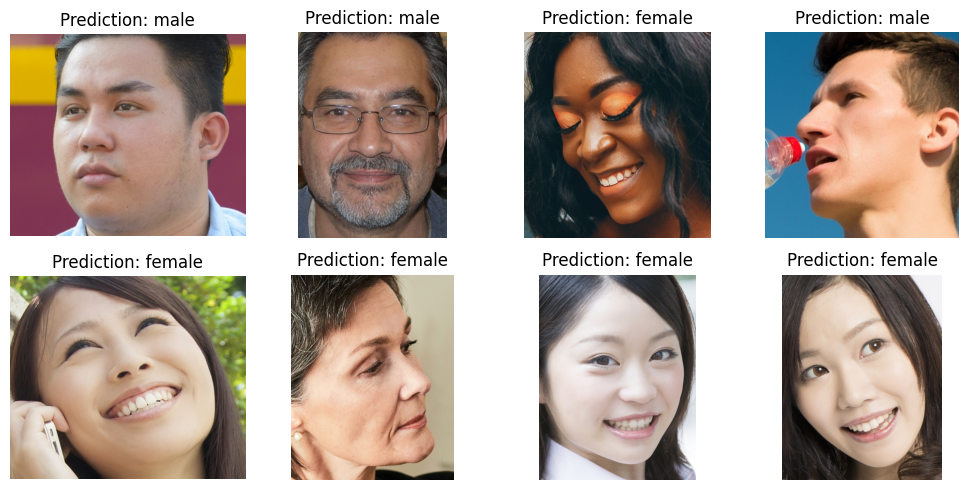

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()